In [79]:
using Particles, Distributions, ConjugatePriors
using ConjugatePriors: NormalInverseWishart

# Stickiness

Want to model "sticky" transitions between components (in order to deal with runs).  There are a few complications: need to take into account the ambiguity in same-component transitions (could be that you randomly picked the same, or that you stuck), and that affects how you count state assignments for CRP purposes (as well as sampling new values for the stickiness parameter which is important).

## `particles` state prior with stickiness: ✔

Currently: sufficient statistics are stored on components.  Need to augment those to keep track of self-transitions (in addition to total state occupations).  Ideally this could be handled with a generalized representation of the state transition prior in the particle/component somehow.  Where does that information come in?

* `fit(p::Particle, y, x::Int)`: use trickery to efficiently get the log-probability ratio, by subtracting/adding the log-count.
* `marginal_log_posterior`

How about replacing α with a prior struct?  Then need to be able to do

* prior probability given current state. (requires different sufficient statistics potentially)
* joint prior probability of a bunch of observations with labels already.

Question is then where you put the sufficient statistics...

I mean you could replace the `Particle/InfiniteParticle` distinction with this too since you really do the putative index generation based on the prior.  But is that really worth it??  Need to encapsulate the sufficient stats for the prior somehow, but why not do that _on the prior struct_ itself?  A la the `Component` abstraction...

## CRP component of sticky state prior

One subtlety is in how to properly compute the state-transition prior when there's a constant stickiness.  The generative model is simple enough: sample a "sticky" indicator with constant probability $s_i \sim \mathrm{Bernoulli}(\rho)$, and conditional on that the following state (same if $s_i = 1$, from a Chinese Restaurant Process otherwise.  The issue is that when the state doesn't change, that could be because of stickiness _or_ because that state was randomly chosen as a non-sticky transition.  And _that_ depends on how likely each state is a priori, and hence on whether other, previous assignments to that state are stickiness or not, etc....

The basic difficulty is that the CRP requries that you be able to integrate out the actual parameter which has the state probabilities.  I don't know that that's really possible here, unfortunately.

Now I see why the HDP-HMM approach is very clever.  Using a hierarchical approach lets you use the counts for transitions from each state encode the stickiness: you put your thumb on the scale with their $\kappa$ param, which then leads to more self-transitions when there's less data which gets perpetuated in the following trials via the normal CRP dynamics.

How to deal with this?  Could explicitly include the "stickiness" indicator variables in the particle state.  Or go to the hierarchical direction.  Or something where we take the limit of infinite lower-level concentration parameter, plus constant $\kappa/\alpha$ ratio?

### Stickiness/override indicator variable in state

In this formulation, there's an additional putative particle with prior weight $\rho$ generated with the same state as the predecessor, and the other particles weights are adjusted by $(1-\rho)$.  This seems quite straightforward, and could even use a special sentinal value of the state (like 0 or -1) to indicate this.  Then keep track of the number of sticking transitions and use that to sample $\rho$ (from a Beta or something).

In [80]:
using JLD2, DataFrames, Underscore, DataFramesMeta

@load "data/dots2014.jld2" recall pred

2-element Array{Symbol,1}:
 :recall
 :pred  

In [81]:
recall

,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp
1,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275
2,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054
3,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827
4,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544
5,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778
6,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024
7,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0
8,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059
9,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423
10,1.0,1.0,10.0,10.0,1.0,0.0,0.01,0.0,0.0,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20.0,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689


In [82]:
prior = NormalInverseWishart(zeros(2), 0.1, eye(2)*0.1*3, 3.)
α = 1.0
ps = ChenLiuParticles(100, prior, ChineseRestaurantProcess(α))

Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess}[0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle  …  0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle, 0+ Particle]

In [83]:
using JuliennedArrays

xys = @with(@where(recall, :subjid1 .== 1), hcat(:x, :y))
xy_vecs = map(vec, julienne(xys, (*,:)))

Particle filter with 100 particles:


200-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1}:
 [0.0318469, 0.00562752]   
 [0.0278656, 0.000370634]  
 [-0.0160184, -0.000520783]
 [0.0504518, -0.00401431]  
 [-0.0312425, -0.000984465]
 [0.00850297, -0.000448522]
 [0.0312967, 0.00292533]   
 [0.0355355, 0.00415872]   
 [-0.00730868, 0.00151658] 
 [0.0403416, -0.00260159]  
 [0.00976546, 0.00171756]  
 [0.0023686, 0.000115442]  
 [0.0546225, 0.00575101]   
 ⋮                         
 [-0.0525185, -0.20348]    
 [-0.0952235, -0.151854]   
 [-0.0422029, -0.226154]   
 [-0.235441, -0.377386]    
 [-0.0520006, -0.241261]   
 [-0.075919, -0.262445]    
 [-0.0902533, -0.158258]   
 [-0.123231, -0.187603]    
 [-0.293629, -0.247625]    
 [-0.151276, -0.262387]    
 [-0.0930733, -0.447663]   
 [-0.230315, -0.340811]    

In [84]:
filter!(ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:03


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess}[8+ Particle, 9+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 9+ Particle, 8+ Particle, 8+ Particle  …  8+ Particle, 8+ Particle, 9+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle, 8+ Particle]

In [85]:
weight.(ps.particles)

Particle filter with 100 particles:


100-element Array{Float64,1}:
 0.0084404 
 0.00626399
 0.0125463 
 0.0116807 
 0.0129696 
 0.00838554
 0.0128444 
 0.0058723 
 0.0101502 
 0.0137966 
 0.00661733
 0.013299  
 0.0184719 
 ⋮         
 0.0075139 
 0.00752637
 0.0208621 
 0.00920537
 0.00516299
 0.0151755 
 0.0142939 
 0.00950765
 0.00782557
 0.00552252
 0.00836489
 0.00932289

In [86]:
sort!(ps.particles, by=weight)

100-element Array{Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess},1}:
 8+ Particle
 9+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 9+ Particle
 8+ Particle
 9+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 9+ Particle
 ⋮          
 8+ Particle
 9+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 8+ Particle
 8+ Particle

In [87]:
assignments(ps)

200×100 Array{Int64,2}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1     1  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  1  1  1  1  

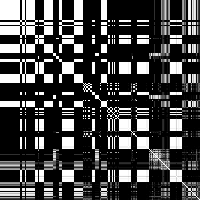

In [88]:
using Colors, Images
Gray.(assignment_similarity(ps))

In [89]:
sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.5))
filter!(sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:03


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[8+ Particle, 9+ Particle, 9+ Particle, 8+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle  …  9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle]

Particle filter with 100 particles:


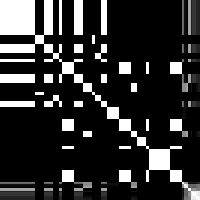

In [90]:
Gray.(assignment_similarity(sticky_ps))

In [91]:
really_sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.9))
filter!(really_sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:03


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 8+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle  …  10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 8+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle, 10+ Particle]

Particle filter with 100 particles:


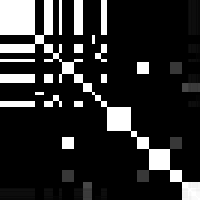

In [92]:
Gray.(assignment_similarity(really_sticky_ps))

In [93]:
barely_sticky_ps = ChenLiuParticles(100, prior, StickyCRP(α, 0.1))
filter!(barely_sticky_ps, xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:03


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[6+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 8+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle  …  7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 7+ Particle, 8+ Particle, 7+ Particle, 7+ Particle]

Particle filter with 100 particles:


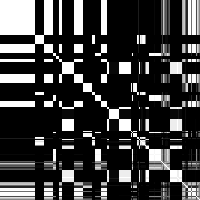

In [94]:
Gray.(assignment_similarity(barely_sticky_ps))

Fitting particles...100%|███████████████████████████████| Time: 0:00:38


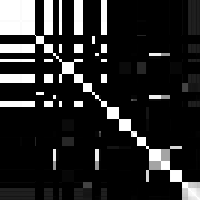

In [95]:
using Underscore

@_ ChenLiuParticles(1000, prior, StickyCRP(10., 0.7)) |>
    filter!(_, xy_vecs) |>
    assignment_similarity |>
    Gray.(_)

Fitting particles...100%|███████████████████████████████| Time: 0:00:32


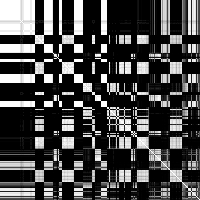

In [96]:
using Underscore

@_ ChenLiuParticles(1000, prior, ChineseRestaurantProcess(10.)) |>
    filter!(_, xy_vecs) |>
    assignment_similarity |>
    Gray.(_)

# Data by subject

In [97]:
sub1 = @where(recall, :subjid1 .== 1)
sub2 = @where(recall, :subjid1 .== 2)

using Plots, StatPlots

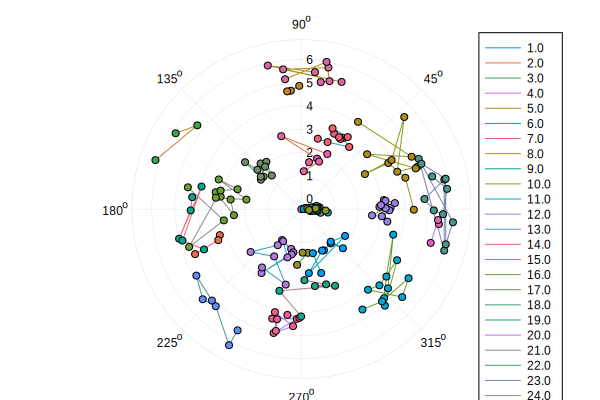

In [98]:
@with(sub1, plot(:theta, :rho, group=:block, seriestype=[^(:path), ^(:scatter)], proj=^(:polar)))

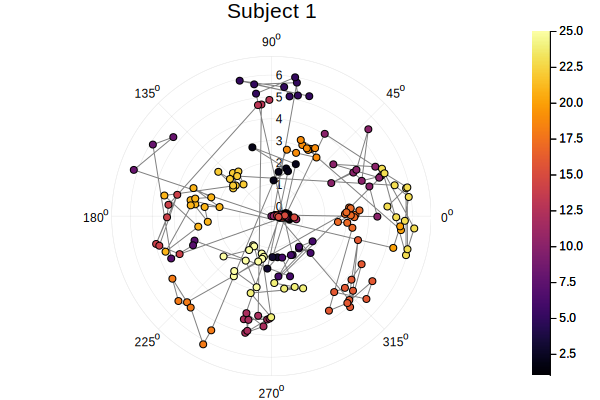

In [99]:
@df sub1 plot(:theta, :rho, seriestype=:path, proj=:polar, color="gray")
@df sub1 plot!(:theta, :rho, seriestype=:scatter, markerz=:block, legend=false)
title!("Subject 1")

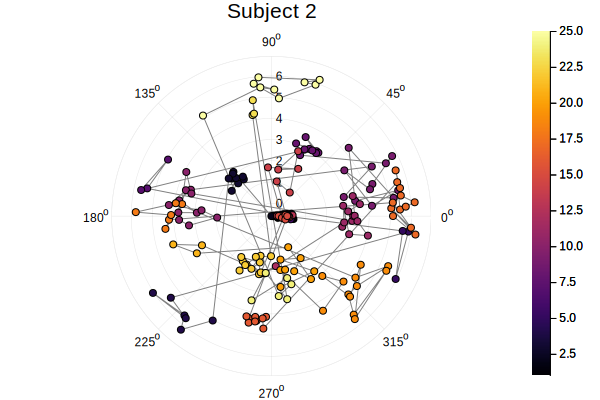

In [100]:
@df sub2 plot(:theta, :rho, seriestype=:path, proj=:polar, color="gray")
@df sub2 plot!(:theta, :rho, markerz=:block, seriestype=:scatter, legend=false)
title!("Subject 2")

The clusters are the same but they occur in different orders for each subject.

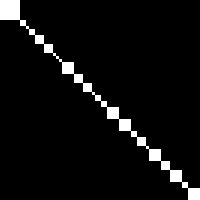

In [101]:
Gray.(@with(sub1, :block .== :block'))

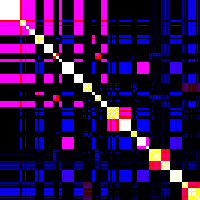

In [102]:
colorview(RGB, assignment_similarity(really_sticky_ps), @with(sub1, :block .== :block'), assignment_similarity(ps))

# Modeling recall

Recall is a combination of the actual remembered location and the category.  If the distributions are both normal then it's just the inverse-variance weighted average of the means.  I'm not sure how that works when there's uncertainty about the actual distribution...but it might be close enough when there's more than a few observations from the category.  Or not.  At the very least could sample from the posterior and then do the combination.

The precision-weighted average model of cue combination comes from a normal-normal model.  The normal-inverse-wishart model is a normal-normal model, conditioned on a sample of the variance.  So we can approximate it in one of two ways: sample a few covariance matrices and average the resulting predictions, or use the expected covariance matrix as a good guess.

Either way we have to average over particles anyway...

In [103]:
p = really_sticky_ps.particles[1]

p.assignment

10

In [104]:
c = p.components[1]

typeof(c)

Particles.Component{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats}

In [105]:
fieldnames(c)

2-element Array{Symbol,1}:
 :prior    
 :suffstats

In [106]:
using ConjugatePriors: posterior

In [107]:
post = posterior(c.prior, c.suffstats)

ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [0.0307026, -0.0198556]
kappa: 62.1
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.756188 -0.2258; 0.0 1.22999]
nu: 65.0
)


The predictive distribution is Normal, with covariance $S_{mem} = \Sigma_n + \kappa_n^{-1}\Sigma_n = \frac{1+\kappa_n}{\kappa_n} \Sigma_N = \frac{1+\kappa_n}{\kappa_n (\nu_n - d + 1)} \Lambda_n $.  The precision is $S_{mem}^{-1} = \frac{\kappa_n (\nu_n - d + 1)}{1+\kappa_n} \Lambda_n^{-1}$

Combine that with a uncertain memory trace which is going to have MvNormal uncertainty with covariance $S_x$ and mean $x$...

Then the reconstructed (recalled) value is the inverse-variance weighted estimate:

$$\hat{x} = (S_{mem}^{-1} + S_x^{-1})^{-1} (S_{mem}^{-1} \mu + S_x^{-1} x)$$

In [108]:
using BenchmarkTools

@btime full(inv($(post.Lamchol)))
@btime inv(full($(post.Lamchol)))

  705.305 ns (2 allocations: 128 bytes)
  2.077 μs (15 allocations: 1.94 KiB)


2×2 Array{Float64,2}:
 1.80774   0.197374
 0.197374  0.660993

In [109]:
full(inv(post.Lamchol)) ≈ inv(full(post.Lamchol))

true

In [110]:
using Distributions: MvNormalStats

ConjugatePriors.posterior(c::Component) = posterior(c.prior, c.suffstats)

function recall_est(x::AbstractVector{Float64}, Sx::Matrix{Float64}, c::Component{NormalInverseWishart{Float64}}) 
    Sinv_x = inv(Sx)
    post = posterior(c)
    Sinv_mem = full(inv(post.Lamchol)) .* (post.kappa / (1+post.kappa) * (post.nu - post.dim + 1))
    Sinv_total = Sinv_x + Sinv_mem
    return Sinv_total \ (Sinv_mem * post.mu + Sinv_x * x)
end

recall_est (generic function with 4 methods)

In [111]:
xy_vecs[end]

2-element SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true}:
 -0.230315
 -0.340811

In [112]:
recall_est(xy_vecs[end], eye(2), p.components[p.assignment])

2-element Array{Float64,1}:
 -0.0721766
 -0.333211 

## Filtering

Now we need to add some kind of method to filter a data point and aggregate the estimates as we go.  The `filter!` method takes a vector of observations and just calls `fit!` on each one.  Could add some kind of callback to that, or just do it manually.

In [113]:
function Base.reset(particles::ChenLiuParticles) 
    N = length(particles.particles)
    p = particles.particles[1]
    return ChenLiuParticles(N, p.prior.prior, p.stateprior; rejuv=particles.rejuvination_threshold)
end

In [114]:
extrema(xys, 1)

1×2 Array{Tuple{Float64,Float64},2}:
 (-0.933307, 0.968406)  (-0.869892, 0.939818)

In [115]:
# This ONLY MAKES SENSE when x is the last datapoint fit (e.g., as a callback from filter!)

recall_est(x::AbstractVector, Sx::Matrix, p::Particles.AbstractParticle) =
    recall_est(x, Sx, p.components[p.assignment])

function recall_est(x::AbstractVector, Sx::Matrix, ps::ParticleFilter)
    xy_recalled = mapreduce(p -> recall_est(x, Sx, p) .* weight(p), +, particles(ps))
    xy_recalled ./= sum(weight.(particles(ps)))
    return xy_recalled
end

mutable struct RecallFilter{P}
    particles::P
    Sx::Matrix{Float64}
    recalled::Vector{Vector{Float64}}
end

RecallFilter(particles::ParticleFilter, Sx::Matrix{Float64}) =
    RecallFilter(particles, Sx, Vector{Vector{Float64}}())

function Base.filter!(rf::RecallFilter, xys::AbstractVector)
    callback = (p, x) -> push!(rf.recalled, recall_est(x, rf.Sx, p))
    filter!(rf.particles, xys, cb=callback)
    rf
end

In [116]:
rf = filter!(RecallFilter(ChenLiuParticles(1000, prior, StickyCRP(α, 0.9)), eye(2)*sqrt(0.01)),
        xy_vecs)

Fitting particles...100%|███████████████████████████████| Time: 0:00:40


RecallFilter{Particles.ChenLiuParticles{Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}}}(Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle  …  9+ Particle, 9+ Particle, 8+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle], [0.1 0.0; 0.0 0.1], Array{Float64,1}[[0.0308519, 0.0054517], [0.0281231, 0.00153727], [0.000342573, 0.000711268], [0.0336111, -0.00137257], [-0.00294697, -0.000310633], [0.01058, -0.000160177], [0.0191235, 0.00109351], [0.0218122, 0.00170654], [0.00915404, 0.00106798], [0.0220804, -0.000107505]  …  [0.018277, -0.0983954], [-0.0957914, -0.446312], [-0.0381132, -0.350143], [-0.0430769, -0.343917], [-0.024617, -0.205823], [-0.027718, -0.186131], [-0

Particle filter with 1000 particles:


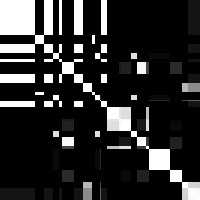

In [117]:
Gray.(assignment_similarity(rf.particles))

In [118]:
Sx = eye(2) * sqrt(0.01)
recalled = Vector{Vector{Float64}}()
ps2 = filter!(ChenLiuParticles(1000, prior, StickyCRP(α, 0.9)), xy_vecs, 
              cb=(p,y)->push!(recalled, recall_est(y, Sx, p)))

Fitting particles...100%|███████████████████████████████| Time: 0:00:39


Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.StickyCRP}[9+ Particle, 9+ Particle, 9+ Particle, 11+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 10+ Particle, 9+ Particle, 9+ Particle  …  9+ Particle, 11+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 9+ Particle, 10+ Particle, 10+ Particle, 11+ Particle, 11+ Particle]

Particle filter with 1000 particles:


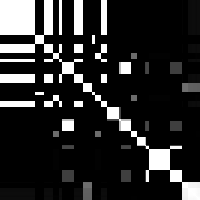

In [119]:
Gray.(assignment_similarity(ps2))

In [120]:
recalled

200-element Array{Array{Float64,1},1}:
 [0.0308519, 0.0054517]     
 [0.0281221, 0.00153619]    
 [0.000573347, 0.000730778] 
 [0.0337236, -0.00137059]   
 [-0.00282126, -0.000298045]
 [0.0106614, -0.000149206]  
 [0.0191611, 0.00110271]    
 [0.021797, 0.00170635]     
 [0.009257, 0.00107981]     
 [0.0220983, -9.43042e-5]   
 [0.014975, 0.000903532]    
 [0.0126931, 0.000548407]   
 [0.0247943, 0.00188063]    
 ⋮                          
 [-0.0103657, -0.330192]    
 [0.00673905, -0.123343]    
 [0.0181383, -0.0986076]    
 [-0.0855489, -0.43919]     
 [-0.0326214, -0.33563]     
 [-0.0363355, -0.325747]    
 [-0.0215164, -0.202301]    
 [-0.0265067, -0.189963]    
 [-0.114122, -0.322918]     
 [-0.0824348, -0.325431]    
 [-0.0676784, -0.393909]    
 [-0.106777, -0.356782]     

In [121]:
rf.recalled

200-element Array{Array{Float64,1},1}:
 [0.0308519, 0.0054517]     
 [0.0281231, 0.00153727]    
 [0.000342573, 0.000711268] 
 [0.0336111, -0.00137257]   
 [-0.00294697, -0.000310633]
 [0.01058, -0.000160177]    
 [0.0191235, 0.00109351]    
 [0.0218122, 0.00170654]    
 [0.00915404, 0.00106798]   
 [0.0220804, -0.000107505]  
 [0.0149431, 0.00089827]    
 [0.0126687, 0.000543689]   
 [0.024778, 0.0018769]      
 ⋮                          
 [-0.0125207, -0.336263]    
 [0.00636174, -0.121189]    
 [0.018277, -0.0983954]     
 [-0.0957914, -0.446312]    
 [-0.0381132, -0.350143]    
 [-0.0430769, -0.343917]    
 [-0.024617, -0.205823]     
 [-0.027718, -0.186131]     
 [-0.131174, -0.325628]     
 [-0.103687, -0.328479]     
 [-0.0845134, -0.414114]    
 [-0.125533, -0.370008]     

In [122]:
norm.(recalled .- xy_vecs)

200-element Array{Float64,1}:
 0.00101042
 0.00119345
 0.0166389 
 0.0169358 
 0.0284296 
 0.00217909
 0.0122717 
 0.0139557 
 0.0165714 
 0.0184148 
 0.00527275
 0.0103336 
 0.0300782 
 ⋮         
 0.133539  
 0.105874  
 0.1411    
 0.162134  
 0.096338  
 0.0746593 
 0.0816364 
 0.0967526 
 0.194658  
 0.0933468 
 0.0594512 
 0.124566  

In [123]:
norm.(recalled) .- norm.(xy_vecs)

200-element Array{Float64,1}:
 -0.00101042 
  0.000295957
 -0.0150981  
 -0.0168598  
 -0.0284211  
  0.00214766 
 -0.0122403  
 -0.0139144  
  0.0018554  
 -0.0183269  
  0.00508688 
  0.0103335  
 -0.0300588  
  ⋮          
  0.120206   
 -0.0557133  
 -0.129797   
  0.00263767 
  0.0904099  
  0.0545622  
  0.0212569  
 -0.0326532  
 -0.0416142  
  0.0328373  
 -0.0575558  
 -0.0389188  

In [124]:
xy_resp_vecs = @_ recall |> 
    @where(_, :subjid1 .== 1) |> 
    @with(_, hcat(:x_resp, :y_resp)) |> 
    map(vec, julienne(_, (*,:)))

200-element Array{SubArray{Float64,1,Array{Float64,2},Tuple{Int64,Base.OneTo{Int64}},true},1}:
 [-0.010458, -0.0418275]  
 [0.00813932, -0.00465054]
 [-0.0685536, -0.0278827] 
 [0.070865, -0.0348544]   
 [0.0941047, -0.0859778]  
 [-0.0267245, -0.0488024] 
 [0.103403, 0.0]          
 [-0.0267275, -0.0883059] 
 [-0.0197503, 0.0139423]  
 [0.0197581, 0.00929689]  
 [0.00116183, 0.0]        
 [-0.00348551, 0.00464732]
 [0.019753, -0.0441498]   
 ⋮                        
 [0.00812914, -0.132454]  
 [-0.05229, -0.123161]    
 [-0.117332, -0.23934]    
 [-0.321814, -0.427567]   
 [-0.18474, -0.146389]    
 [-0.140581, -0.188224]   
 [-0.0360104, -0.111532]  
 [-0.161493, -0.202172]   
 [-0.245143, -0.206814]   
 [-0.268382, -0.239356]   
 [-0.0801695, -0.313703]  
 [-0.219569, -0.362502]   

In [125]:
resp_dev_rad = norm.(xy_vecs .- xy_resp_vecs)

200-element Array{Float64,1}:
 0.0635742 
 0.0203553 
 0.0592336 
 0.0369839 
 0.151446  
 0.0598253 
 0.0721656 
 0.111474  
 0.0175839 
 0.0237751 
 0.00877339
 0.00740327
 0.0608767 
 ⋮         
 0.0933959 
 0.0516388 
 0.0762776 
 0.0998919 
 0.163158  
 0.0984379 
 0.0715931 
 0.0409428 
 0.0633755 
 0.119349  
 0.13458   
 0.0242066 

In [126]:
pred_dev_rad = norm.(xy_vecs .- recalled)

200-element Array{Float64,1}:
 0.00101042
 0.00119345
 0.0166389 
 0.0169358 
 0.0284296 
 0.00217909
 0.0122717 
 0.0139557 
 0.0165714 
 0.0184148 
 0.00527275
 0.0103336 
 0.0300782 
 ⋮         
 0.133539  
 0.105874  
 0.1411    
 0.162134  
 0.096338  
 0.0746593 
 0.0816364 
 0.0967526 
 0.194658  
 0.0933468 
 0.0594512 
 0.124566  

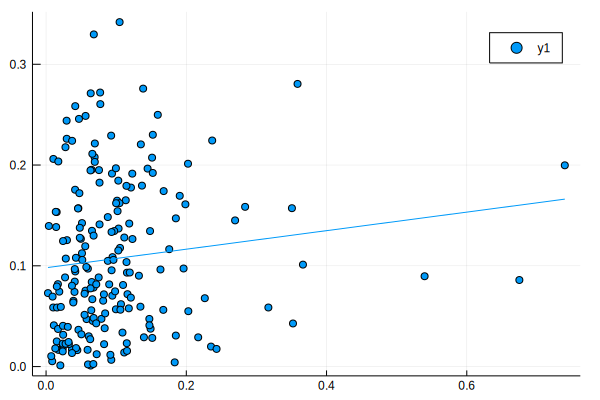

In [127]:
plot(resp_dev_rad, pred_dev_rad, seriestype = :scatter, smooth=true)

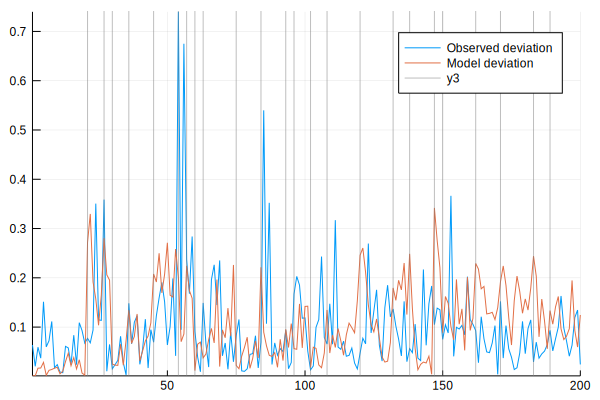

In [128]:
plot(hcat(resp_dev_rad, pred_dev_rad), lab=["Observed deviation", "Model deviation"])

@_ recall |> 
    @where(_, :subjid1.==1, :new_block .== 1) |> 
    @df _ plot!(:respnr, seriestype=:vline, color=GrayA(0.5, 0.5))

In [129]:
cor(resp_dev_rad, pred_dev_rad)

0.11953521456732502

In [130]:
pred_radius = norm.(recalled)

200-element Array{Float64,1}:
 0.0313299  
 0.028164   
 0.000928851
 0.0337514  
 0.00283696 
 0.0106624  
 0.0191928  
 0.0218637  
 0.00931977 
 0.0220985  
 0.0150022  
 0.0127049  
 0.0248656  
 ⋮          
 0.330354   
 0.123527   
 0.100262   
 0.447444   
 0.337211   
 0.327768   
 0.203442   
 0.191803   
 0.34249    
 0.335709   
 0.39968    
 0.372417   

In [131]:
hcat(recalled...)'

200×2 Array{Float64,2}:
  0.0308519     0.0054517  
  0.0281221     0.00153619 
  0.000573347   0.000730778
  0.0337236    -0.00137059 
 -0.00282126   -0.000298045
  0.0106614    -0.000149206
  0.0191611     0.00110271 
  0.021797      0.00170635 
  0.009257      0.00107981 
  0.0220983    -9.43042e-5 
  0.014975      0.000903532
  0.0126931     0.000548407
  0.0247943     0.00188063 
  ⋮                        
 -0.0103657    -0.330192   
  0.00673905   -0.123343   
  0.0181383    -0.0986076  
 -0.0855489    -0.43919    
 -0.0326214    -0.33563    
 -0.0363355    -0.325747   
 -0.0215164    -0.202301   
 -0.0265067    -0.189963   
 -0.114122     -0.322918   
 -0.0824348    -0.325431   
 -0.0676784    -0.393909   
 -0.106777     -0.356782   

# Plots

## Bias by radius

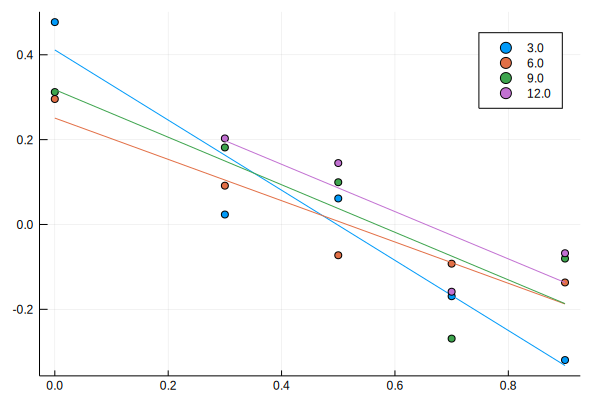

In [235]:
plot_bias_by_radius = d -> @_ d |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], new_rho_bias = mean(:new_rho_bias)) |>
    @with(_, plot(:rad, :new_rho_bias, group=:rep_number, smooth=true, seriestype=^([:scatter])))
plot_bias_by_radius(recall)

In [288]:
macro tmp(sym)
    esc(:(
        @where(_, :block .> 1) |>
        @by(_, [:rad, :rep_number], new_rho_bias = mean(:($sym))) |>
        @with(_, plot(:rad, :new_rho_bias, group=:rep_number, smooth=true, seriestype=^([:scatter])))
        ))
end
(@macroexpand @tmp new_rho_bias) |> dump


Expr
  head: Symbol call
  args: Array{Any}((3,))
    1: Symbol |>
    2: Expr
      head: Symbol call
      args: Array{Any}((3,))
        1: Symbol |>
        2: Expr
          head: Symbol call
          args: Array{Any}((3,))
            1: DataFramesMeta.where (function of type DataFramesMeta.#where)
            2: Symbol _
            3: Expr
              head: Symbol ->
              args: Array{Any}((2,))
                1: Symbol ##2526
                2: Expr
              typ: Any
          typ: Any
        3: Expr
          head: Symbol call
          args: Array{Any}((4,))
            1: DataFrames.by (function of type DataFrames.#by)
            2: Symbol _
            3: Expr
              head: Symbol vect
              args: Array{Any}((2,))
                1: QuoteNode
                2: QuoteNode
              typ: Any
            4: Expr
              head: Symbol ->
              args: Array{Any}((2,))
                1: Symbol ##2529
                2: Expr
     

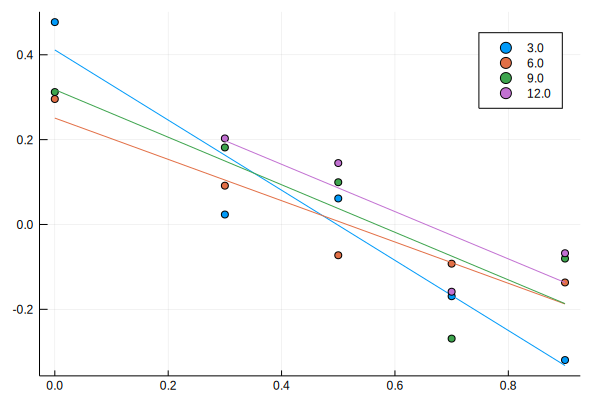

In [245]:
sym = :new_rho_bias
f = eval(quote
    d->@_ d |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], new_rho_bias = mean(:($sym))) |>
    @with(_, plot(:rad, :new_rho_bias, group=:rep_number, smooth=true, seriestype=^([:scatter])))
        end)
f(recall)

LoadError: [91mUndefVarError: macrocall not defined[39m

## Just first subject

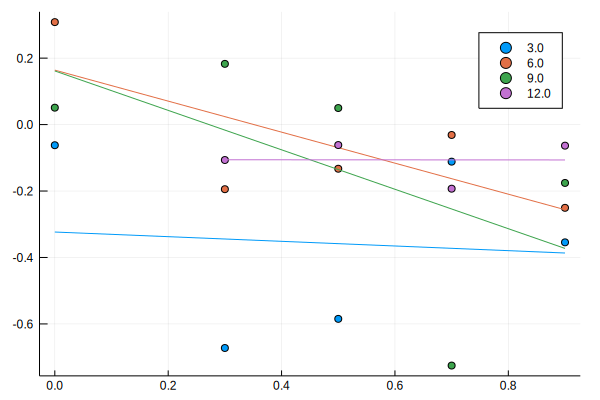

In [234]:
@_ recall |>
    @where(_, :subjid1 .== 1) |>
    plot_bias_by_radius

Extremely noisy!

## All subjects

In [134]:
model_recall(d::AbstractDataFrame, N::Int, prior::NormalInverseWishart, stateprior, Sx::Matrix) =
    model_recall(d, ChenLiuParticles(N, prior, stateprior), Sx)

function model_recall(d::AbstractDataFrame, ps::ParticleFilter, Sx::Matrix)
    xy_vecs = map(vec, julienne(hcat(d[:x], d[:y]), (*,:)))
    ps = filter!(RecallFilter(ps, Sx), xy_vecs)
    hcat(d, 
         DataFrame(x_mod = first.(ps.recalled),
                   y_mod = last.(ps.recalled),
                   rho_mod = norm.(ps.recalled)))
end

model_recall (generic function with 3 methods)

In [135]:
methods(model_recall)

# 3 methods for generic function "model_recall":
model_recall(d::DataFrames.AbstractDataFrame, ps::KnownFilter, Sx::Array{T,2} where T) in Main at In[76]:2
model_recall(d::DataFrames.AbstractDataFrame, N::Int64, prior::ConjugatePriors.NormalInverseWishart, stateprior, Sx::Array{T,2} where T) in Main at In[134]:1
model_recall(d::DataFrames.AbstractDataFrame, ps::Particles.ParticleFilter, Sx::Array{T,2} where T) in Main at In[134]:5

In [136]:
@_ recall |>
    @where(_, :subjid1 .== 1) |>
    model_recall(_, 100, prior, StickyCRP(1.0, 0.9), eye(2))

Fitting particles...100%|███████████████████████████████| Time: 0:00:04


,subjid1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,x_mod,y_mod,rho_mod
1,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,0.029416,0.00519796,0.0298717
2,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,0.0283778,0.00260849,0.0284974
3,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,0.0110711,0.0015355,0.011177
4,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,0.0244824,4.84135e-5,0.0244825
5,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,0.0101769,4.11184e-5,0.010177
6,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,0.0115699,-1.40468e-5,0.0115699
7,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,0.015092,0.000508331,0.0151006
8,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,0.0177378,0.000996541,0.0177657
9,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,0.013738,0.000964864,0.0137718
10,1.0,1.0,10.0,10.0,1.0,0.0,0.01,0.0,0.0,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20.0,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689,0.0175964,0.000511476,0.0176038


In [137]:
recall_mod = by(recall, :subjid1, d->model_recall(d, 100, prior, StickyCRP(1.0, 0.9), eye(2).*0.00000001))

Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:05
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /home/dave/.julia/v0.6/DataFrames/src/other/index.jl:190
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#76(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at

,subjid1,subjid1_1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,x_mod,y_mod,rho_mod
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,0.0318469,0.00562752,0.0323403
2,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,0.0278656,0.000370634,0.027868
3,1.0,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,-0.0160184,-0.000520782,0.0160269
4,1.0,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,0.0504518,-0.00401431,0.0506113
5,1.0,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,-0.0312425,-0.000984465,0.031258
6,1.0,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,0.00850297,-0.000448522,0.00851479
7,1.0,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,0.0312967,0.00292533,0.0314331
8,1.0,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,0.0355355,0.00415872,0.035778
9,1.0,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,-0.00730867,0.00151658,0.00746436
10,1.0,1.0,1.0,10.0,10.0,1.0,0.0,0.01,0.0,0.0,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20.0,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689,0.0403415,-0.00260159,0.0404253


# Sanity checks

## Visualizing recall bias


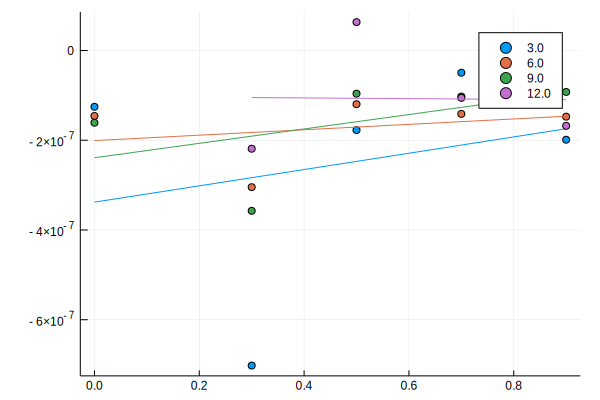

In [139]:
@_ hcat(recall, recall_mod, makeunique=true) |>
    @transform(_, pred_rho_bias = :rho_mod.*2π .- abs.(:rho)) |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], pred_rho_bias = mean(:pred_rho_bias)) |>
    @df(_, plot(:rad, :pred_rho_bias, group=:rep_number, smooth=true, seriestype=:scatter))


Okay that's more like it.  A mess.  (and very small biases overall, which makes sense because of the very small $S_x$).  So what happens if we run it with ...

## Reasonable amount of uncertainty ($S_x$)

In [140]:
recall_mod_Sx1 = by(recall, :subjid1, d->model_recall(d, 100, prior, StickyCRP(1.0, 0.9), eye(2)))

Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:05
Fitting particles...100%|███████████████████████████████| Time: 0:00:05
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:05
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /home/dave/.julia/v0.6/DataFrames/src/other/index.jl:190
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#76(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at

,subjid1,subjid1_1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,x_mod,y_mod,rho_mod
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,0.029416,0.00519796,0.0298717
2,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,0.0283778,0.00260849,0.0284974
3,1.0,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,0.0110711,0.0015355,0.011177
4,1.0,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,0.0244923,5.35053e-5,0.0244924
5,1.0,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,0.00978653,3.1614e-5,0.00978659
6,1.0,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,0.0114787,-1.69216e-5,0.0114787
7,1.0,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,0.0149898,0.000509866,0.0149985
8,1.0,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,0.0176477,0.000988772,0.0176754
9,1.0,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,0.013738,0.000964864,0.0137718
10,1.0,1.0,1.0,10.0,10.0,1.0,0.0,0.01,0.0,0.0,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20.0,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689,0.0175964,0.000511476,0.0176038


### Bias as a function of radius and run length

Qualitatively similar: bias has a negative slope (shrinkage), more bias for shorter runs.  But the slope difference isn't there (although it's not clear whether it's _really_ there in the data), and the bias is zero at radius zero, _not_ at the average radius.

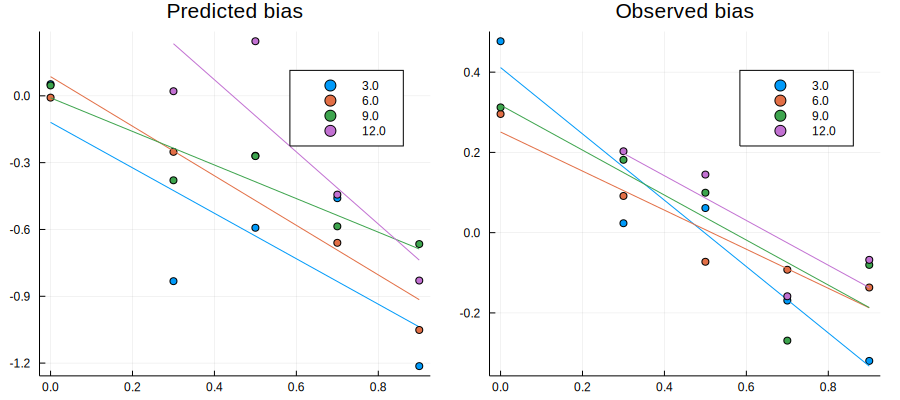

In [141]:
@_ recall_mod_Sx1 |>
    @transform(_, pred_rho_bias = :rho_mod.*2π .- abs.(:rho)) |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], pred_rho_bias = mean(:pred_rho_bias), new_rho_bias = mean(:new_rho_bias)) |>
    @df(_, plot(plot(:rad, :pred_rho_bias, group=:rep_number, smooth=true, seriestype=:scatter, 
                     title="Predicted bias"),
                plot(:rad, :new_rho_bias, group=:rep_number, smooth=true, seriestype=:scatter, 
                     title="Observed bias"),
                size=(900,400)))

However it looks like the _relative_ effect of the block length is exaggerated in the predictions:

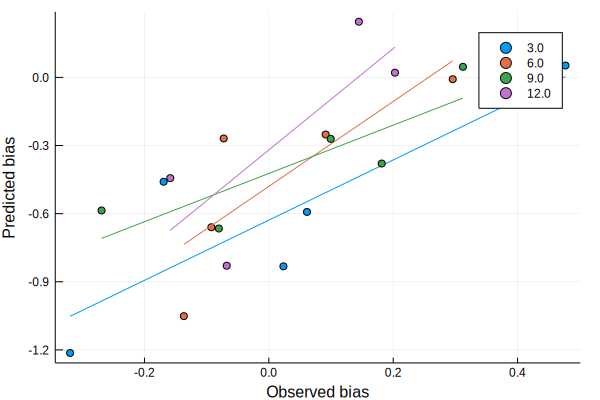

In [142]:
@_ recall_mod_Sx1 |>
    @transform(_, pred_rho_bias = :rho_mod.*2π .- abs.(:rho)) |> 
    @where(_, :block .> 1) |>
    @by(_, [:rad, :rep_number], pred_rho_bias = mean(:pred_rho_bias), rho_bias = mean(:new_rho_bias)) |>
    @df(_, scatter(:rho_bias, :pred_rho_bias, group=:rep_number, smooth=true,
                   xlabel="Observed bias", ylabel="Predicted bias"))


## Plotting single-trial deviations

This shows the (predicted) deviation for subject 1, over the course of the experiment.  You can see that rather extreme shrinkage towards inferred clusters is predicted with this level of sensory uncertainty (and stickiness, likely):

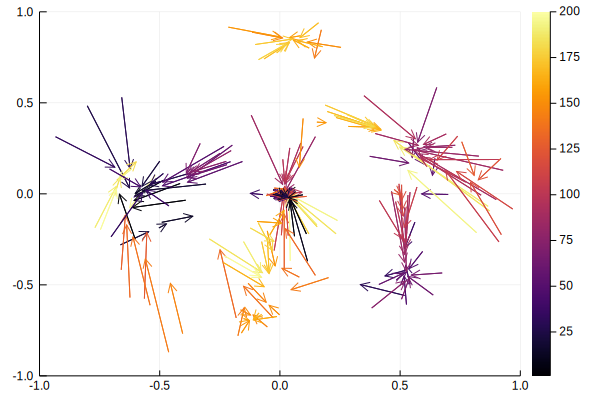

In [143]:
@_ recall_mod_Sx1 |>
    @where(_, :subjid1.==1) |>
    @df(_,
        quiver(:x, :y, 
               quiver=(:x_mod.-:x, :y_mod.-:y), 
               linez=:respnr,
               xlimits=(-1,1), ylimits=(-1,1)))

This does not match the qualitative patterns we see in the behavior of one subject:

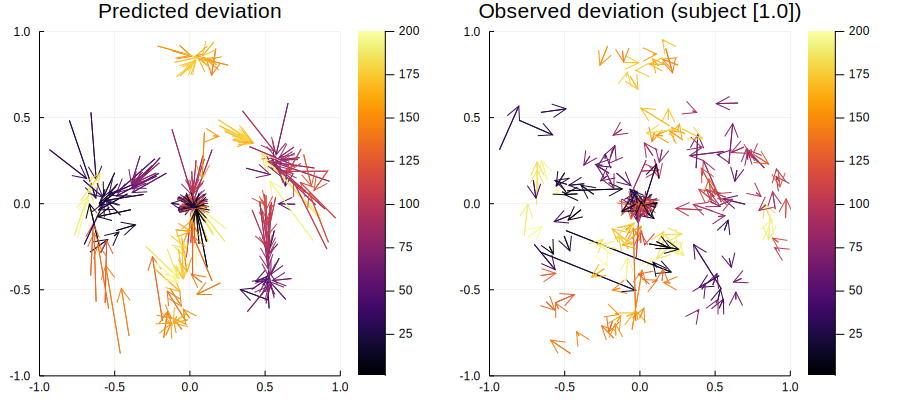

In [144]:

@_ recall_mod_Sx1 |>
    @where(_, :subjid1 .== 1) |>
    @df(_, plot(quiver(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), 
                       linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                       title = "Predicted deviation"),
                 quiver(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), 
                         linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                        title="Observed deviation (subject $(unique(:subjid1)))"),
                 size=(900, 400)))

In [145]:
rho(x) = sqrt(mapreduce(x->x^2, +, x))

rho (generic function with 1 method)

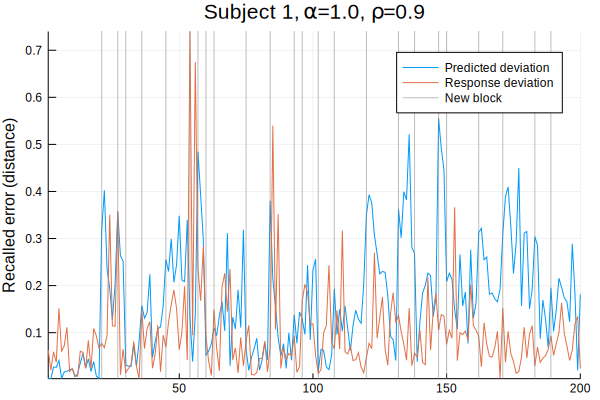

In [146]:
@_ recall_mod_Sx1 |>
    @where(_, :subjid1.==1) |>
    @transform(_, 
               dev_mod = map(rho, zip(:x.-:x_mod, :y.-:y_mod)), 
               dev_resp = map(rho, zip(:x.-:x_resp, :y.-:y_resp))) |>
    @df _ plot(hcat(:dev_mod, :dev_resp), labels=["Predicted deviation", "Response deviation"])

@_ recall_mod_Sx1 |>
    @where(_, :subjid1.==1, :new_block .== 1) |>
    @df _ plot!(:respnr, seriestype=:vline, label="New block", color=GrayA(0.5, 0.5))

title!("Subject 1, \\alpha=1.0, \\rho=0.9")
ylabel!("Recalled error (distance)")

# Alternative models

## Updating with correct breaks

Another sanity check is what happens when we _know_ where the block breaks are.

In [147]:
p = InfiniteParticle(prior, StickyCRP(1., 0.9))

  (prior: ConjugatePriors.NormalInverseWishart{Float64}([0.0, 0.0], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.547723 0.0; 0.0 0.547723], 0.1, 3.0) w/ n=0)


In [148]:
recall1 = @where(recall, :subjid1 .== 1)
xyi = @with recall1 map((x,y,i) -> ([x,y], round(Int,i)), :x, :y, :block)
p = foldl((p, xyi) -> fit(p, xyi[1], xyi[2]), 
      InfiniteParticle(prior, StickyCRP(1., 0.9)), 
      xyi)

Particle with 0+ components:


  ConjugatePriors.NormalInverseWishart{Float64}([0.0169213, 0.000119075], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.562545 0.000885396; 0.0 0.548087], 20.1, 23.0) w/ n=20
  ConjugatePriors.NormalInverseWishart{Float64}([0.0433775, 0.283159], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.585827 -0.0310601; 0.0 0.583515], 6.1, 9.0) w/ n=6
  ConjugatePriors.NormalInverseWishart{Float64}([0.00532999, -0.247779], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.549268 0.00414004; 0.0 0.557592], 3.1, 6.0) w/ n=3
  ConjugatePriors.NormalInverseWishart{Float64}([-0.00197381, -0.00220736], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.554725 0.00189332; 0.0 0.547856], 6.1, 9.0) w/ n=6
  ConjugatePriors.NormalInverseWishart{Float64}([0.0592984, 0.851346], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.715472 -0.0228166; 0.0 0.628987], 9.1, 12.0) w/ n=9
  ConjugatePriors.NormalInverseWishart{Float64}([0.135255, -

In [149]:
recall_est(xyi[end][1], Sx, p)

Particle with 25+ components:


2-element Array{Float64,1}:
 -0.151412
 -0.277896

In [150]:
xyi[end]

([-0.230315, -0.340811], 25)

In [151]:
mutable struct KnownFilter{P} <: ParticleFilter
    p::P
end

KnownFilter(prior::Distribution) = KnownFilter(InfiniteParticle(prior, ChineseRestaurantProcess(1.0)))

Particles.particles(ps::KnownFilter) = [ps.p]

function StatsBase.fit!(ps::KnownFilter, yi::Tuple{T, Int}) where T
    ps.p = fit(ps.p, yi...)
    ps
end

recall_est(xyi::Tuple{AbstractVector, Int}, Sx, ps) = recall_est(xyi[1], Sx, ps)

recall_est (generic function with 4 methods)

In [152]:
filter!(KnownFilter(prior), xyi)

KnownFilter{Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess}}(  ConjugatePriors.NormalInverseWishart{Float64}([0.0169213, 0.000119075], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.562545 0.000885396; 0.0 0.548087], 20.1, 23.0) w/ n=20
  ConjugatePriors.NormalInverseWishart{Float64}([0.0433775, 0.283159], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.585827 -0.0310601; 0.0 0.583515], 6.1, 9.0) w/ n=6
  ConjugatePriors.NormalInverseWishart{Float64}([0.00532999, -0.247779], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.549268 0.00414004; 0.0 0.557592], 3.1, 6.0) w/ n=3
  ConjugatePriors.NormalInverseWishart{Float64}([-0.00197381, -0.00220736], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.554725 0.00189332; 0.0 0.547856], 6.1, 9.0) w/ n=6
  ConjugatePriors.NormalInverseWishart{Float64}([0.0592984, 0.851346], Base.LinAlg.Cholesky{Floa

In [153]:
rf_known= filter!(RecallFilter(KnownFilter(prior), eye(2)), xyi)

Particle with 25+ components:


RecallFilter{KnownFilter{Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess}}}(KnownFilter{Particles.InfiniteParticle{ConjugatePriors.NormalInverseWishart{Float64},Distributions.MvNormalStats,Particles.ChineseRestaurantProcess}}(  ConjugatePriors.NormalInverseWishart{Float64}([0.0169213, 0.000119075], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.562545 0.000885396; 0.0 0.548087], 20.1, 23.0) w/ n=20
  ConjugatePriors.NormalInverseWishart{Float64}([0.0433775, 0.283159], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.585827 -0.0310601; 0.0 0.583515], 6.1, 9.0) w/ n=6
  ConjugatePriors.NormalInverseWishart{Float64}([0.00532999, -0.247779], Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.549268 0.00414004; 0.0 0.557592], 3.1, 6.0) w/ n=3
  ConjugatePriors.NormalInverseWishart{Float64}([-0.00197381, -0.00220736], Base.LinAlg.Cholesky{Float64,Array{Float64,2}}

In [190]:
function model_recall(d::AbstractDataFrame, ps::KnownFilter, Sx::Matrix, add=true)
    xy_vecs = collect(zip(map(vec, julienne(hcat(d[:x], d[:y]), (*,:))), round.(Int, d[:block])))
    ps = filter!(RecallFilter(ps, Sx), xy_vecs)
    recalled = DataFrame(x_mod = first.(ps.recalled),
                         y_mod = last.(ps.recalled),
                         rho_mod = norm.(ps.recalled))
    return add ? hcat(d, recalled) : recalled
end

model_recall (generic function with 4 methods)

In [155]:
@time recalled_known = by(recall, :subjid1, d->model_recall(d, KnownFilter(prior), Matrix(0.05I, 2,2)))

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /home/dave/.julia/v0.6/DataFrames/src/other/index.jl:190
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#76(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:840
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] hcat!(::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:849
 [7] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /home/dave/.julia/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [8] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /home/dave/.julia/v0.6/DataFrames/src/groupeddataframe/gr

0.363441 seconds (459.23 k allocations: 21.202 MiB)


,subjid1,subjid1_1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,x_mod,y_mod,rho_mod
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,0.0312462,0.00552137,0.0317302
2,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,0.0280425,0.00114391,0.0280658
3,1.0,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,-0.00441283,0.000360577,0.00442754
4,1.0,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,0.038256,-0.00206733,0.0383118
5,1.0,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,-0.00989814,-0.000452795,0.00990849
6,1.0,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,0.0102004,-0.000206493,0.0102025
7,1.0,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,0.0218067,0.00150126,0.0218583
8,1.0,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,0.0245847,0.00220141,0.0246831
9,1.0,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,0.00610412,0.00116058,0.00621347
10,1.0,1.0,1.0,10.0,10.0,1.0,0.0,0.01,0.0,0.0,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20.0,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689,0.0253681,-0.000536793,0.0253737


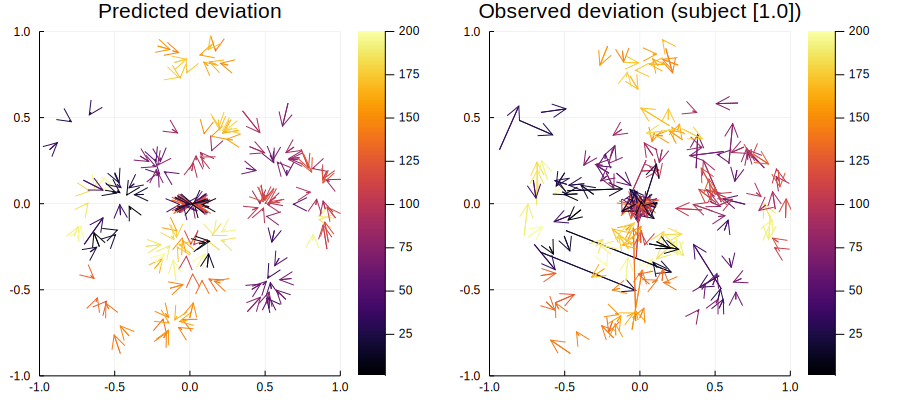

In [156]:

@_ recalled_known |>
    @where(_, :subjid1 .== 1) |>
    @df(_, plot(quiver(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), 
                       linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                       title = "Predicted deviation"),
                 quiver(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), 
                         linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                        title="Observed deviation (subject $(unique(:subjid1)))"),
                 size=(900, 400)))

## Finding a good prior

Let's use these results to find a good prior for the cluster parameters.  Start by fitting the actual distributions, then we'll see about finding a prior that fits _behavior_ well (if possible).

In [167]:
suffstats_true = @_ recall |>
    @where(_, :subjid1 .== 1) |>
    @by(_, :block, suffstats = suffstats(MvNormal, hcat(:x, :y)')) |>
    @with(_, :suffstats)

Particles.marginal_log_lhood.(prior, suffstats_true)

25-element Array{Float64,1}:
 26.7693   
 -0.564152 
 -2.28171  
  0.49434  
  0.0222264
  3.14818  
 -2.71078  
 -3.43542  
 -2.16771  
  0.988211 
  4.52865  
  2.968    
 -2.69874  
 -1.92982  
  0.466774 
  3.78668  
  8.71939  
 -2.36779  
  3.73311  
 -2.93367  
  3.77788  
  4.04202  
  1.15411  
 -1.19667  
  6.43925  

In [177]:
pack(x::Vector{Float64}) = NormalInverseWishart(x[1:2], exp(x[3]), LinAlg.Cholesky(exp(x[4])*eye(2), :U), exp(x[5])-1+2)
unpack(d::NormalInverseWishart) = [d.mu..., log(d.kappa), log(d.Lamchol[:U][1]), log(d.nu+1-2)]

unpack(prior)

5-element Array{Float64,1}:
  0.0     
  0.0     
 -2.30259 
 -0.601986
  0.693147

In [178]:
prior

ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: true
mu: [0.0, 0.0]
kappa: 0.1
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.547723 0.0; 0.0 0.547723]
nu: 3.0
)


In [179]:
pack(unpack(prior))

ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: true
mu: [0.0, 0.0]
kappa: 0.10000000000000002
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.547723 0.0; 0.0 0.547723]
nu: 3.0
)


In [186]:
using Optim

res = optimize(x -> -sum(Particles.marginal_log_lhood.(pack(x), suffstats_true)), unpack(prior))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0, ...]
 * Minimizer: [0.043345754234714234,0.020487860197673582, ...]
 * Minimum: -3.332468e+02
 * Iterations: 208
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 356

In [187]:
prior_optimized = pack(Optim.minimizer(res))

ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [0.0433458, 0.0204879]
kappa: 0.025566395614905986
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[0.0723856 0.0; 0.0 0.0723856]
nu: 2.784457899850737
)


  0.191929 seconds (435.01 k allocations: 20.097 MiB)


Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /home/dave/.julia/v0.6/DataFrames/src/other/index.jl:190
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#76(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:840
 [5] (::DataFrames.#kw##hcat!)(::Array{Any,1}, ::DataFrames.#hcat!, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at ./<missing>:0
 [6] hcat!(::DataFrames.DataFrame, ::DataFrames.DataFrame) at /home/dave/.julia/v0.6/DataFrames/src/dataframe/dataframe.jl:849
 [7] combine(::DataFrames.GroupApplied{DataFrames.DataFrame}) at /home/dave/.julia/v0.6/DataFrames/src/groupeddataframe/grouping.jl:202
 [8] by(::DataFrames.DataFrame, ::Symbol, ::Function) at /home/dave/.julia/v0.6/DataFrames/src/groupeddataframe/gr

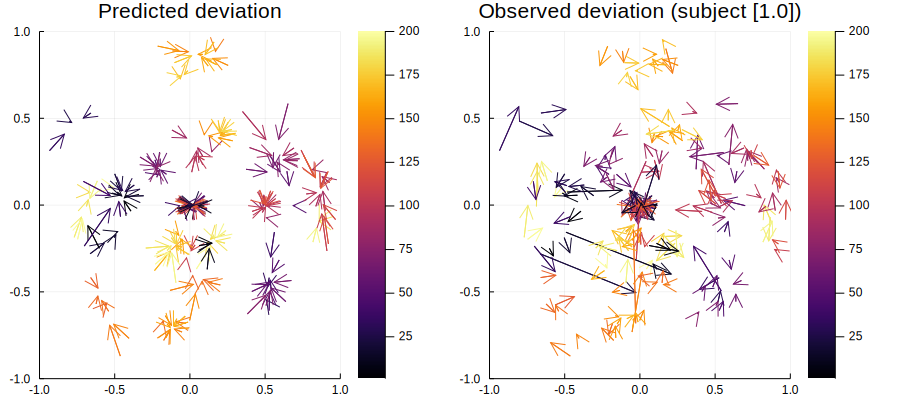

In [188]:
@time recalled_known_opt = by(recall, :subjid1, d->model_recall(d, KnownFilter(prior_optimized), Matrix(0.05I, 2,2)))

@_ recalled_known_opt |>
    @where(_, :subjid1 .== 1) |>
    @df(_, plot(quiver(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), 
                       linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                       title = "Predicted deviation"),
                 quiver(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), 
                         linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                        title="Observed deviation (subject $(unique(:subjid1)))"),
                 size=(900, 400)))

In [212]:
function recall_mse(d, prior, σ) 
    recalled = by(d, :subjid1, d->model_recall(d, KnownFilter(prior), Matrix(σ*I, 2,2), false))
    mean((d[:x_resp] .- recalled[:x_mod]).^2 .+ (d[:y_resp] .- recalled[:y_mod]).^2)
end


recall_mse (generic function with 2 methods)

In [215]:
recall_mse(recall, prior_optimized, 0.05)

0.0314442520804768

In [216]:
σ_res = optimize(logσ -> recall_mse(recall, prior_optimized, exp(logσ)), -10., 10.)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [-10.000000, 10.000000]
 * Minimizer: -6.644895e+00
 * Minimum: 2.781350e-02
 * Iterations: 13
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 14

In [207]:
σ_optimzied = sqrt(exp(Optim.minimizer(σ_res)))

0.0360644599987681

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] exp(::StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/dave/.julia/v0.6/IJulia/src/execute_request.jl:158
 [5] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/dave/.julia/v0.6/Compat/src/Compat.jl:378
 [6] eventloop(::ZMQ.Socket) at /home/dave/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[204], in expression starting on line 1


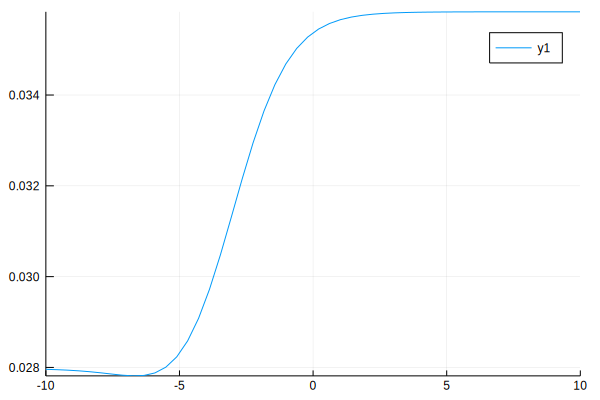

In [204]:
plot(linspace(-10, 10), recall_mse.(recall, exp(linspace(-10,10))))

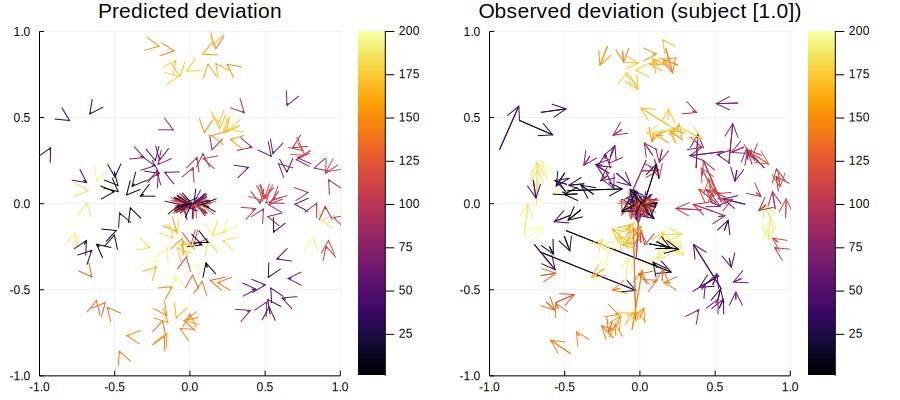

In [211]:
recalled_known_optimized = @_ recall |>
    @where(_, :subjid1 .== 1) |>
    model_recall(_, KnownFilter(prior_optimized), Matrix(σ_optimzied^2 * I, 2, 2))


@_ recalled_known_optimized |>
    @df(_, plot(quiver(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), 
                       linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                       title = "Predicted deviation"),
                 quiver(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), 
                         linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                        title="Observed deviation (subject $(unique(:subjid1)))"),
                 size=(900, 400)))

Okay that's just ridiculous.  What about if we optimize them _together_??

In [218]:
σ_prior_res = optimize(x -> recall_mse(recall, pack(x[2:end]), exp(x[1])), unshift!(unpack(prior_optimized), 0.))

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.043345754234714234, ...]
 * Minimizer: [0.1027713811709189,-0.31897000038175294, ...]
 * Minimum: 2.695924e-02
 * Iterations: 432
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 691

In [223]:
σ_optimized_again = exp(Optim.minimizer(σ_prior_res))[1]

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] exp(::Array{Float64,1}) at ./deprecated.jl:57
 [3] include_string(::String, ::String) at ./loading.jl:522
 [4] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/dave/.julia/v0.6/IJulia/src/execute_request.jl:158
 [5] (::Compat.#inner#18{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/dave/.julia/v0.6/Compat/src/Compat.jl:378
 [6] eventloop(::ZMQ.Socket) at /home/dave/.julia/v0.6/IJulia/src/eventloop.jl:8
 [7] (::IJulia.##14#17)() at ./task.jl:335
while loading In[223], in expression starting on line 1


1.1082380160343317

In [224]:
prior_optimized_again = pack(Optim.minimizer(σ_prior_res)[2:end])

ConjugatePriors.NormalInverseWishart{Float64}(
dim: 2
zeromean: false
mu: [-0.31897, 0.214837]
kappa: 1.3515490814391236
Lamchol: Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
[324.633 0.0; 0.0 324.633]
nu: 18545.927792361716
)


okay this is just bonkers.

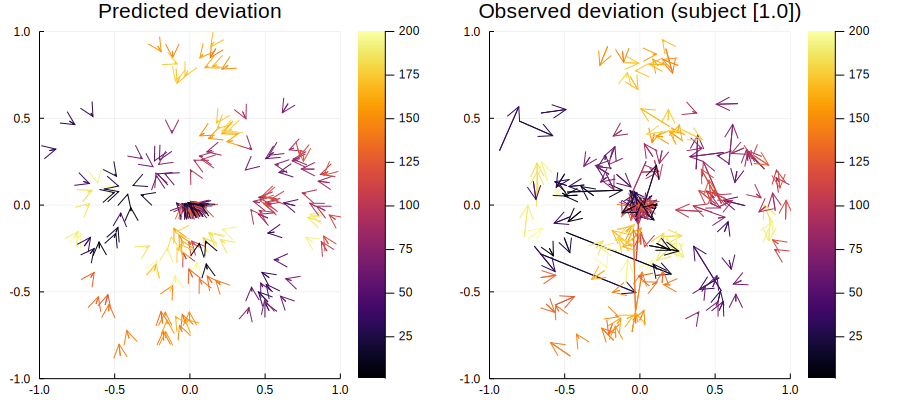

In [226]:
recalled_known_optimized_again = @_ recall |>
    @where(_, :subjid1 .== 1) |>
    model_recall(_, KnownFilter(prior_optimized_again), Matrix(σ_optimized_again^2 * I, 2, 2))


@_ recalled_known_optimized_again |>
    @df(_, plot(quiver(:x, :y, quiver=(:x_mod.-:x, :y_mod.-:y), 
                       linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                       title = "Predicted deviation"),
                 quiver(:x, :y, quiver=(:x_resp.-:x, :y_resp.-:y), 
                         linez=:respnr, xlimits=(-1,1), ylimits=(-1,1),
                        title="Observed deviation (subject $(unique(:subjid1)))"),
                 size=(900, 400)))

In [227]:
recalled_inferred_opt_again = by(recall, :subjid1) do d
    model_recall(d, ChenLiuParticles(100, prior_optimized_again, StickyCRP(α, 0.9)), Matrix(σ_optimized_again*I,2,2))
end


Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:03
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:03
Fitting particles...100%|███████████████████████████████| Time: 0:00:02
Fitting particles...100%|███████████████████████████████| Time: 0:00:03
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Fitting particles...100%|███████████████████████████████| Time: 0:00:04
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] #add_names#18(::Bool, ::Function, ::DataFrames.Index, ::DataFrames.Index) at /home/dave/.julia/v0.6/DataFrames/src/other/index.jl:190
 [3] (::DataFrames.#kw##add_names)(::Array{Any,1}, ::DataFrames.#add_names, ::DataFrames.Index, ::DataFrames.Index) at ./<missing>:0
 [4] #hcat!#76(::Bool, ::Function, ::DataFrames.DataFrame, ::DataFrames.DataFrame) at

,subjid1,subjid1_1,block,rep,respnr,line,rad,var,pred,new_block,correct,resp_time,new_rho_bias,rho,theta_resp,theta,rho_resp,rep_number,new_theta_resp,new_theta_bias,x,y,x_resp,y_resp,x_mod,y_mod,rho_mod
1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.01,0.0,0.0,1.0,3.86993,0.0677,0.2032,-1.8158,0.1749,0.2709,20.0,1.32579,1.15089,0.0318469,0.00562752,-0.010458,-0.0418275,0.00757715,0.0201008,0.0214815
2,1.0,1.0,1.0,2.0,2.0,1.0,0.0,0.01,0.0,0.0,0.0,4.89866,-0.1162,0.1751,-0.5191,0.0133,0.0589,20.0,-0.5191,-0.5324,0.0278656,0.000370634,0.00813932,-0.00465054,0.00938405,0.0120805,0.0152971
3,1.0,1.0,1.0,3.0,3.0,1.0,0.0,0.01,0.0,0.0,1.0,3.27847,0.3643,-0.1007,-2.7553,0.0325,0.465,20.0,0.386293,0.353793,-0.0160184,-0.000520783,-0.0685536,-0.0278827,-0.0273642,0.00952903,0.0289759
4,1.0,1.0,1.0,4.0,4.0,1.0,0.0,0.01,0.0,0.0,0.0,5.18263,0.1782,0.318,-0.4571,-0.0794,0.4962,20.0,-0.4571,-0.3777,0.0504518,-0.00401431,0.070865,-0.0348544,0.0331484,0.00502776,0.0335275
5,1.0,1.0,1.0,5.0,5.0,1.0,0.0,0.01,0.0,0.0,0.0,2.16899,0.6045,-0.1964,-0.7403,0.0315,0.8009,20.0,-0.7403,-0.7718,-0.0312425,-0.000984465,0.0941047,-0.0859778,-0.0368997,0.00665331,0.0374947
6,1.0,1.0,1.0,6.0,6.0,1.0,0.0,0.01,0.0,0.0,1.0,3.50085,0.2961,0.0535,-2.0718,-0.0527,0.3496,20.0,1.06979,1.12249,0.00850297,-0.000448522,-0.0267245,-0.0488024,-0.00162971,0.00633634,0.00654257
7,1.0,1.0,1.0,7.0,7.0,1.0,0.0,0.01,0.0,0.0,1.0,2.95322,0.4522,0.1975,0.0,0.0932,0.6497,20.0,0.0,-0.0932,0.0312967,0.00292533,0.103403,0.0,0.0193031,0.00864552,0.0211507
8,1.0,1.0,1.0,8.0,8.0,1.0,0.0,0.01,0.0,0.0,1.0,3.21443,0.3549,0.2248,-1.8647,0.1165,0.5797,20.0,1.27689,1.16039,0.0355355,0.00415872,-0.0267275,-0.0883059,0.0239182,0.00938618,0.025694
9,1.0,1.0,1.0,9.0,9.0,1.0,0.0,0.01,0.0,0.0,0.0,2.29494,0.105,-0.0469,2.5269,-0.2046,0.1519,20.0,0.956104,1.1607,-0.00730868,0.00151658,-0.0197503,0.0139423,-0.0118985,0.00642143,0.0135207
10,1.0,1.0,1.0,10.0,10.0,1.0,0.0,0.01,0.0,0.0,0.0,3.76106,-0.1168,0.254,0.4398,-0.0644,0.1372,20.0,0.4398,0.5042,0.0403416,-0.00260159,0.0197581,0.00929689,0.0294796,0.00260903,0.0295949
